# Detección de ojos y boca usando YOLOv5





En este ejemplo se diseña desde cero un detector de objetos (en ese caso detección de dos clases, 0: ojo, 1: boca)

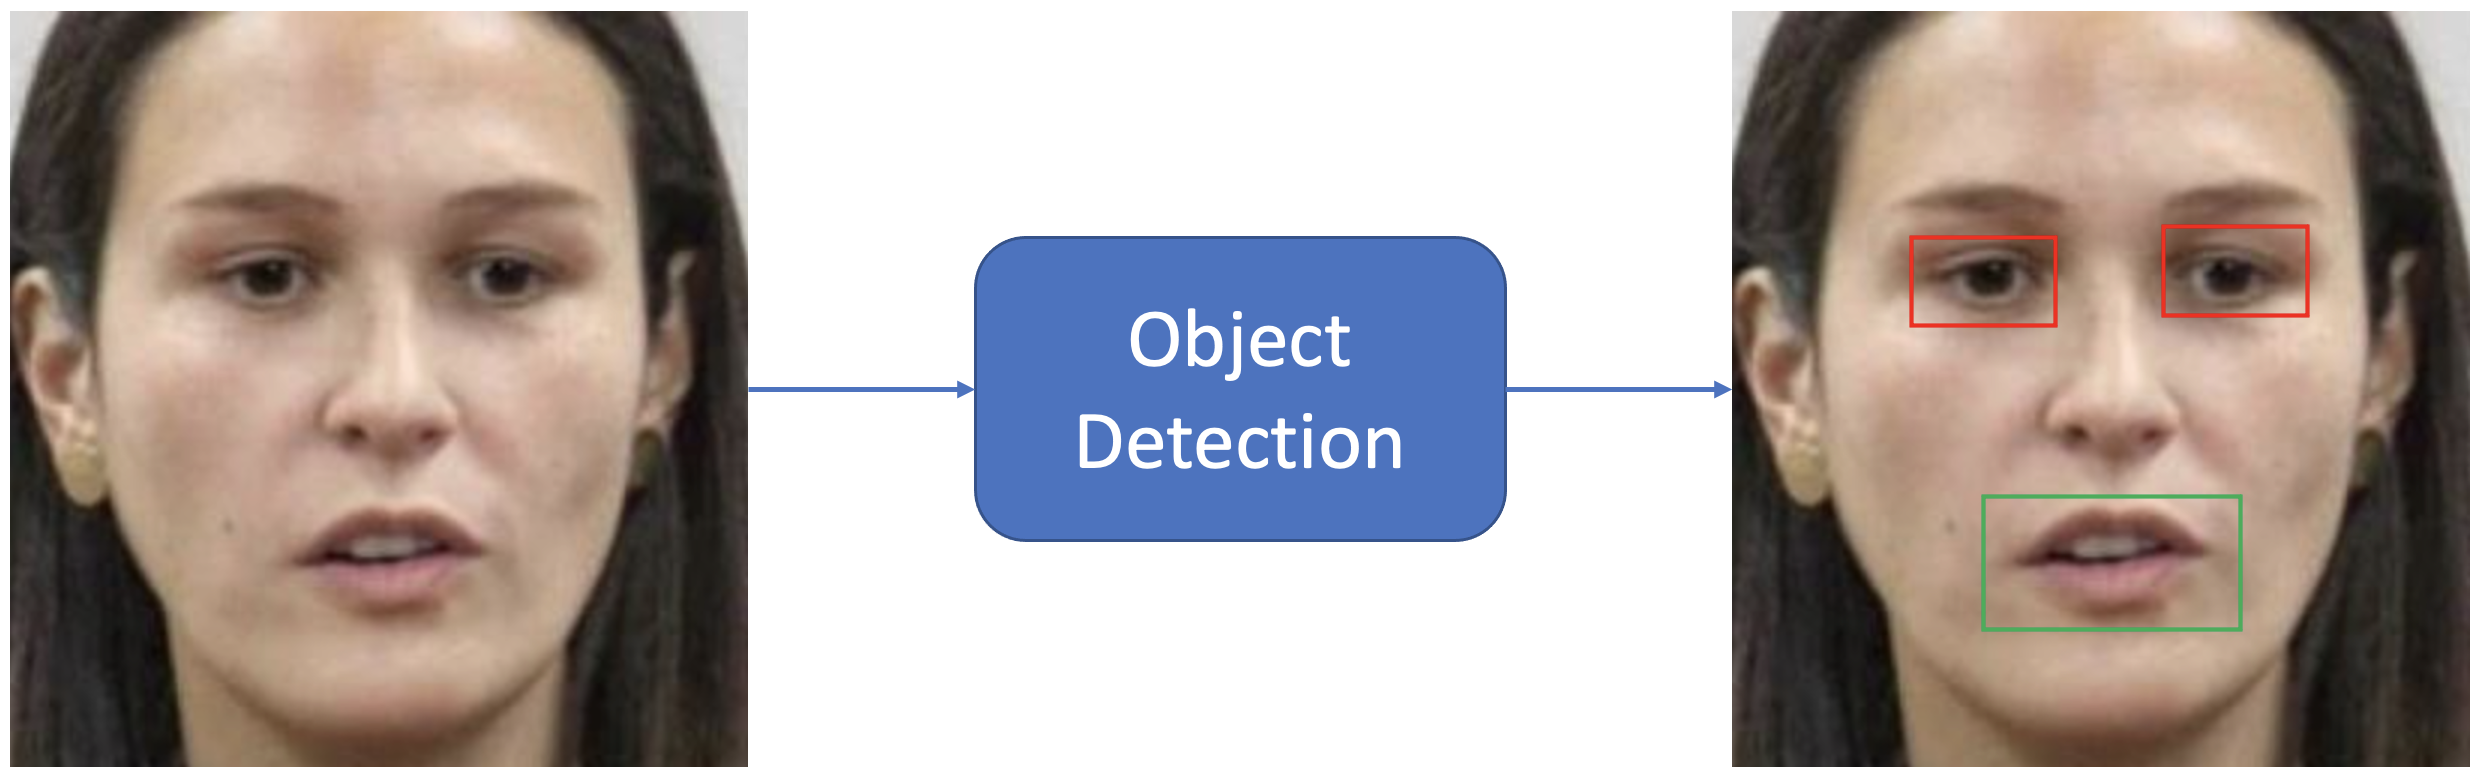

## (1) Definición de Base de Datos

En esta base de datos hay 198 imágenes a color de 33 personas. Cada persona tiene 3 fotos sin mascarilla y 3 fotos con mascarilla. El tamaño de cada imagen es de 256x256 pixeles. El nombre de las imágenes es `FM000xxx_nn.jpg`, donde `xxx` es el ID de la persona, y `nn` es el número de la foto de la persona, con `nn = 0,1,...6`. Las tres primeras fotos de la persona son sin mascarilla, mientras que las últimas tres son con mascarilla.

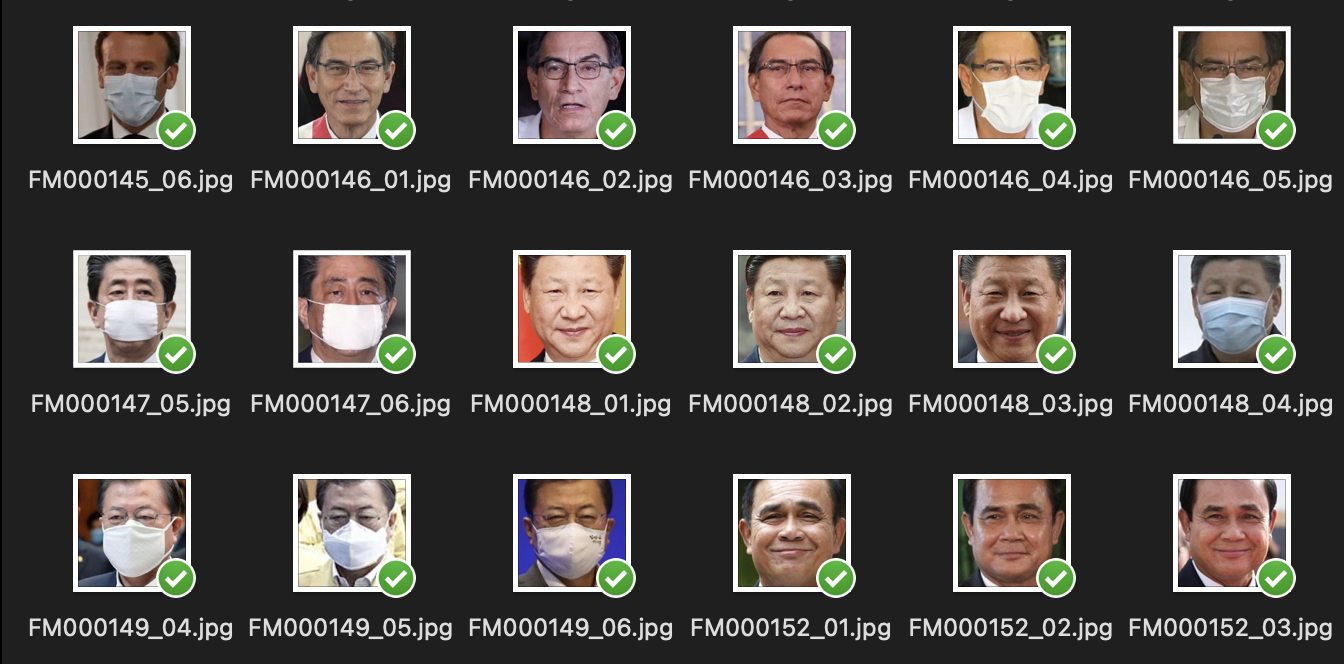

In [ ]:
!unzip -qq images.zip

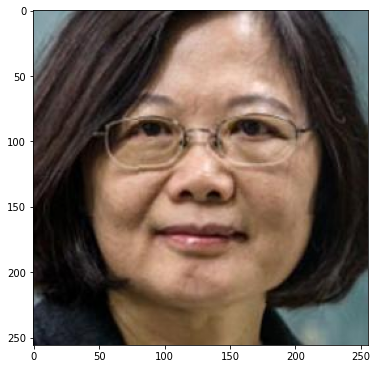

In [ ]:
# Despliegue de una imagen de ejemplo

import cv2
import matplotlib.pyplot as plt

X = cv2.imread('images/FM000008_01.jpg')
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(X, cv2.COLOR_BGR2RGB))
plt.show()


## (2) Anotaciones de bounding boxes y clases

En cada una de las imagenes se marcó manualmente el bounding box de cada ojo y de la boca (en caso de que no haya mascarilla). Un bounding box se define en esta planilla (que puede ser editada con excel) como las esquinas superior izquierda `(x1,y1)` e inferior derecha `(x2,y2)`. Además hay una columna destinada a la clase del bounding box (esta variable llamada `c` es 0 para la clase ojo, y 1 para la clase boca.

## Despliegue de bounding boxes

In [ ]:
import pandas as pd
df = pd.read_csv('boundingbox.csv')
print('Planilla:')
df

Planilla:


File        x1        x2        y1        y2  c
0    FM000008_01.jpg   74.5544  110.1314   84.0287  101.0438  0
1    FM000008_01.jpg  156.1220  188.6185   81.9217  101.4196  0
2    FM000008_01.jpg   91.1291  171.2870  157.8583  187.3547  1
3    FM000008_02.jpg   74.5544  110.1314   84.0287  101.0438  0
4    FM000008_02.jpg  156.1220  188.6185   81.9217  101.4196  0
..               ...       ...       ...       ...       ... ..
490  FM000164_04.jpg  156.1220  188.6185   81.9217  101.4196  0
491  FM000164_05.jpg   74.5544  110.1314   84.0287  101.0438  0
492  FM000164_05.jpg  156.1220  188.6185   81.9217  101.4196  0
493  FM000164_06.jpg   74.5544  110.1314   84.0287  101.0438  0
494  FM000164_06.jpg  156.1220  188.6185   81.9217  101.4196  0

[495 rows x 6 columns]

In [ ]:
import os, fnmatch

def dirfiles(img_path,img_ext):
    img_names = fnmatch.filter(sorted(os.listdir(img_path)),img_ext)
    return img_names

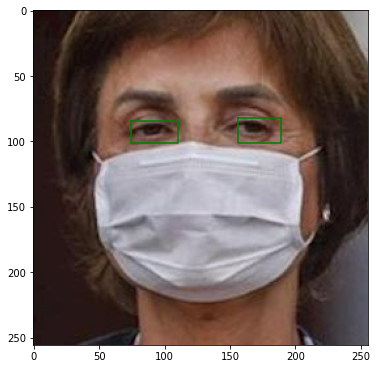

In [ ]:
# Despliegue de los bounding boxes anotados para la imagen i
d = dirfiles('images/','*.jpg')
i = 9
fname = d[i] # nombre de imagen i

X = cv2.imread('images/'+fname)
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(X, cv2.COLOR_BGR2RGB))

n = len(df)
# filas que contienen la imagen con nombre fname 
for k in range(n):
  if df.File[k] == fname:
    x1 = df.x1[k]
    x2 = df.x2[k]
    y1 = df.y1[k]
    y2 = df.y2[k]
    plt.plot([x1,x1,x2,x2,x1],[y1,y2,y2,y1,y1],c='g')

plt.show()

## (3) Formato adecuado para YOLOv5



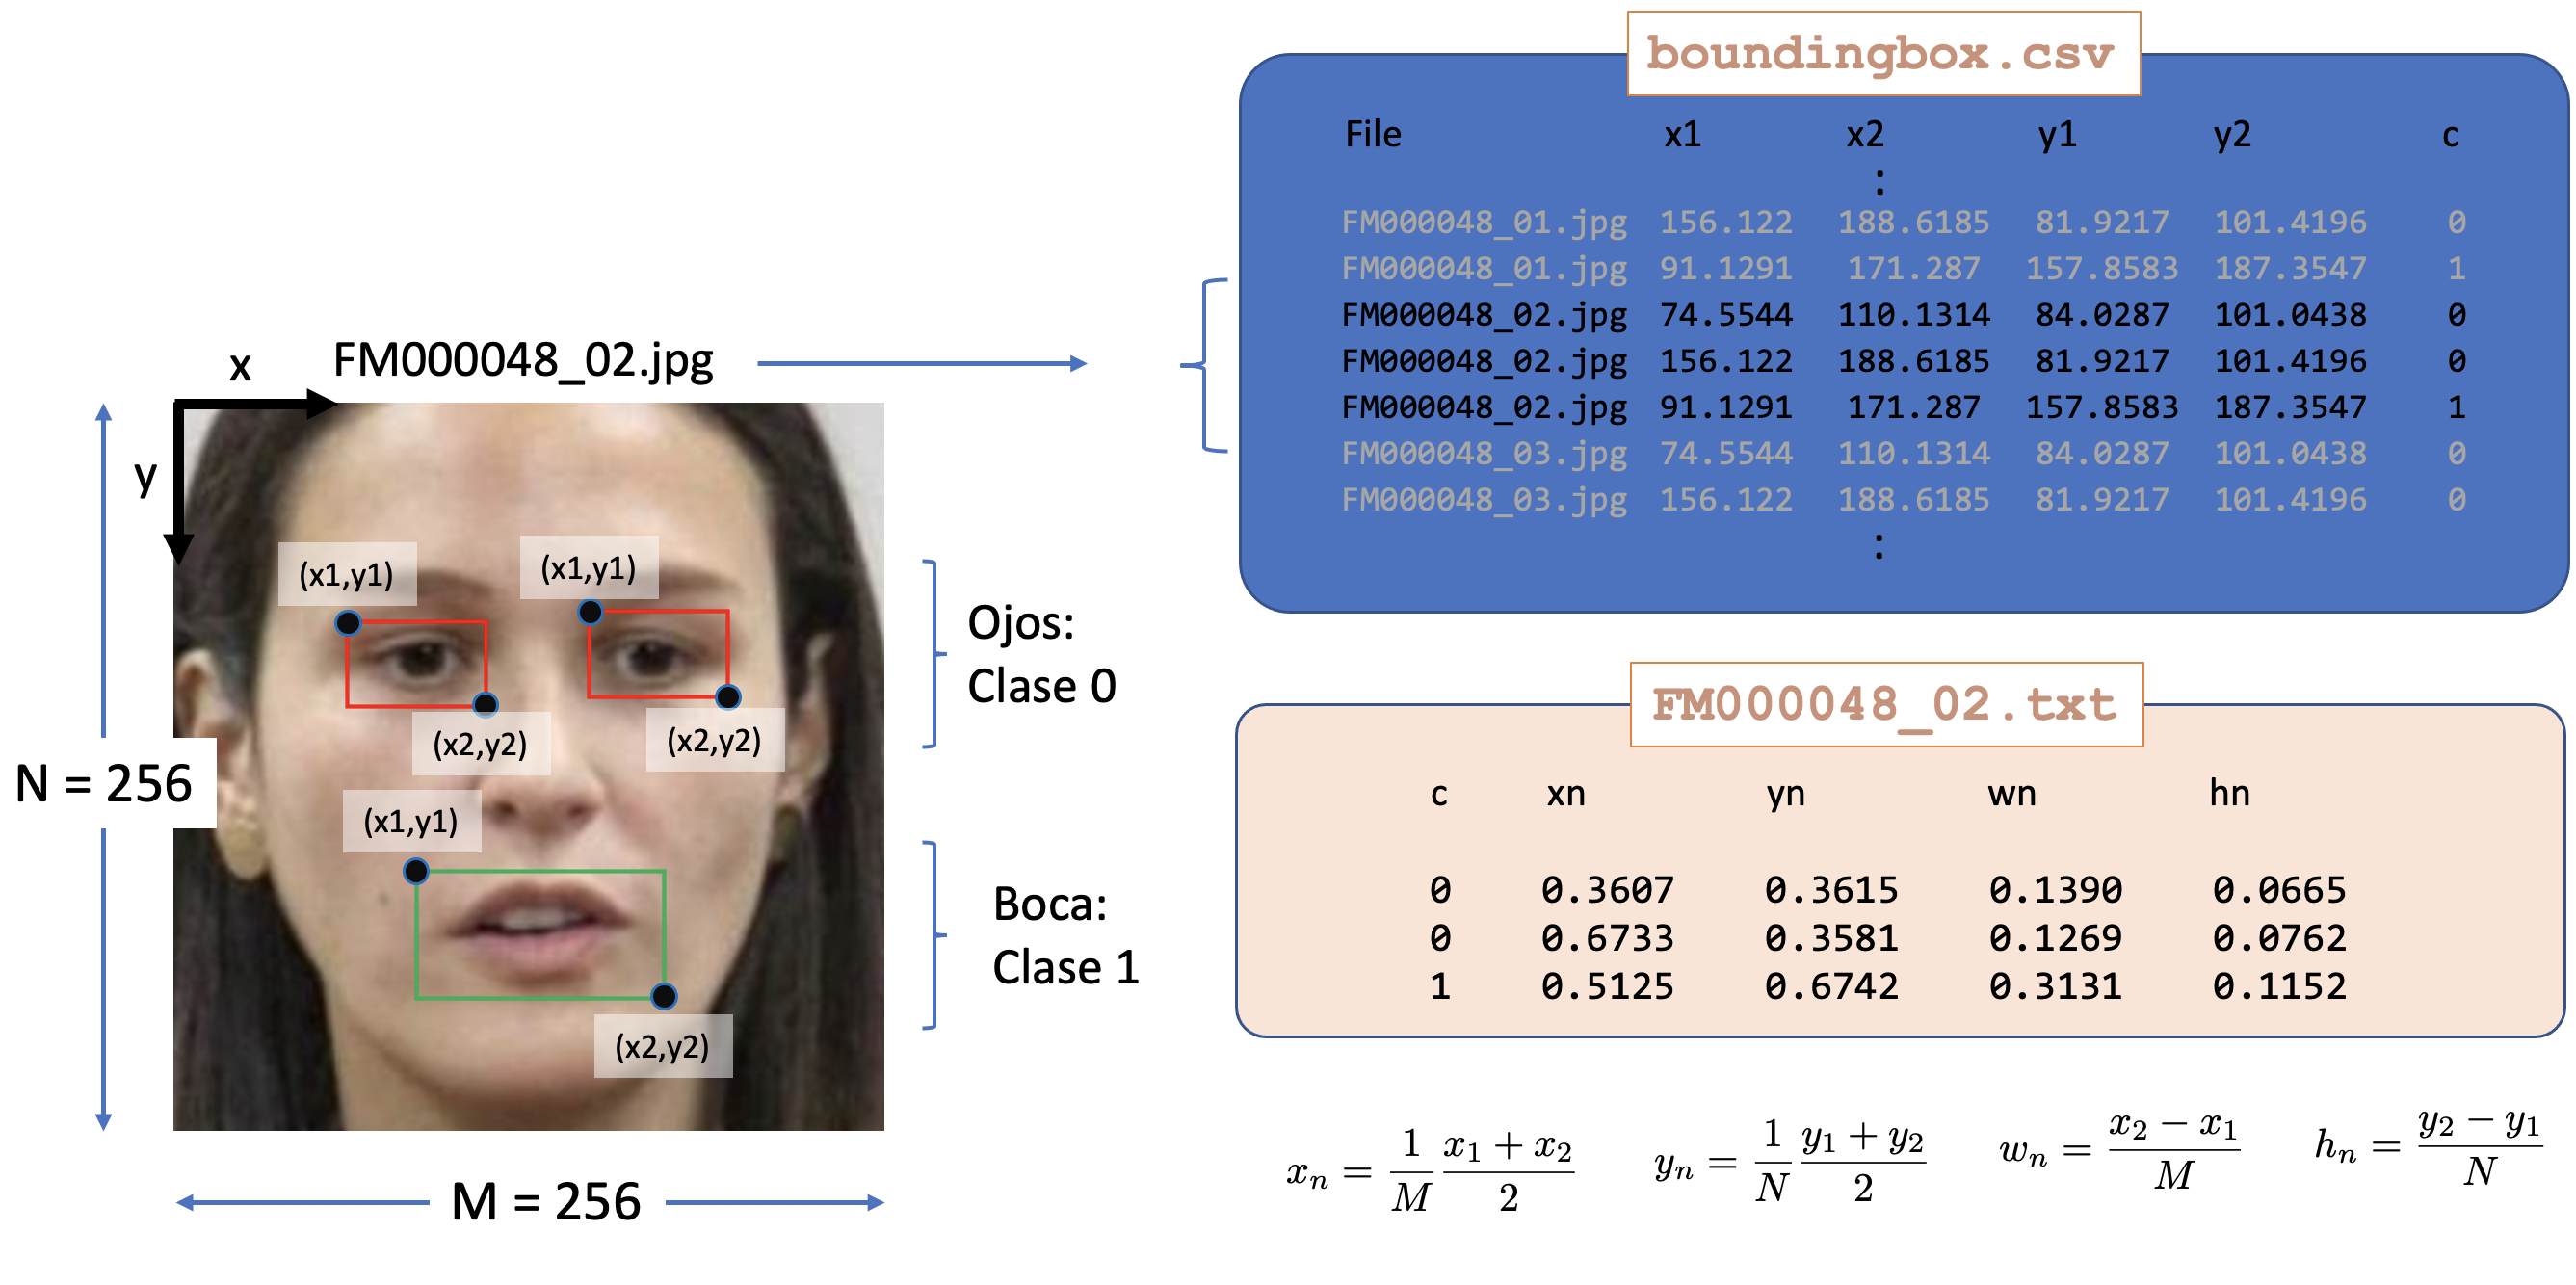

En YOLOv5 es necesario generar un archivo texto por cada imagen que tenga objetos a detectar. Si la imagen se llama `<nombre_imagen>.jpg` y tiene objetos a detectar, debe crearse un archivo `<nombre_imagen>.txt` con $K$ filas, donde $K$ es el número de objetos a detectar que contiene la imagen `<nombre_imagen>.jpg`. Si en la imagen no hay objetos a detectar (por ejemplo una cara con mascarilla y anteojos oscuros), entonces no se genera archivo de texto.

Recordemos que un bounding box se define en esta planilla (que puede ser editada con excel) como las esquinas sup-izq `(x1,y1)` e inf-der `(x2,y2)`. 

Cada una de las $K$ filas de `<nombre_imagen>.txt` contiene 5 números separados por espacios. Los números corresponden a las variables: 

* `c` : número de la clase, en nuestro ejemplo como hay dos clases, `c` puede tomar el valor 0 para ojos, o bien 1 para la boca.

* `xn`: centro del bounding box normalizado en la dirección x, calculado como `xn = (x1+x2)/2/M`, donde `M` es el ancho en pixeles de la imagen.

* `yn`: centro del bounding box normalizado en la dirección y, calculado como `yn = (y1+y2)/2/N`, donde `N` es el alto en pixeles de la imagen.

* `wn`: ancho normalizado del bounding box, calculado como `wn = (x2-x1)/M`, donde `M` es el ancho en pixeles de la imagen.

* `hn`: alto normalizado del bounding box, calculado como `hn = (y2-y1)/N`, donde `N` es el alto en pixeles de la imagen.

In [ ]:
!mkdir labels

In [ ]:
from tqdm.auto import tqdm
m = len(d) # numero de imagenes
n = len(df) # numero de bounding boxes

# en boundingbox.csv las clases son dos (0: ojo, 1:boca)


for i in tqdm(range(m)):
  fname = d[i]
  X = cv2.imread('images/'+fname)
  N = X.shape[0]
  M = X.shape[1]
  # filas que contienen la imagen con nombre fname
  ok = 0
  for k in range(n):
    tname = fname[:-3]+'txt'
    if df.File[k] == fname:
      x1 = df.x1[k]
      x2 = df.x2[k]
      y1 = df.y1[k]
      y2 = df.y2[k]
      c  = df.c[k]
      wn = (x2-x1)/M
      hn = (y2-y1)/N
      xn = (x1+x2)/2/M
      yn = (y1+y2)/2/N
      if ok == 0:
        f = open('labels/'+tname,'w+')
        ok = 1
      f.write(str(c)+' '+str(xn)+' '+str(yn)+' '+str(wn)+' '+str(hn)+'\n')
  if ok:
    f.close()





  0%|          | 0/198 [00:00<?, ?it/s]

## (4) Definición de Train/Val/Test data

Es necesario dividir las imágenes de nuestro dataset en training, validation y testing. En este paso se copian las imágenes (con sus archivos de texto de los labels correspondientes) en los siguientes directorios.

```
data
   |——————images
   |        └——————train —— <trainimage01>.jpg
   |        |               <trainimage02>.jpg
   |        |                      :
   |        └——————val   —— <valimage01>.jpg
   |        |               <valimage02>.jpg
   |        |                      :
   |        └——————test —— <testimage01>.jpg
   |        |               <testimage02>.jpg
   |        |                      :
   └——————labels
   |        └——————train —— <trainimage01>.txt
   |        |               <trainimage02>.txt
   |        |                      :
   |        └——————val   —— <valimage01>.txt
   |        |               <valimage02>.txt
   |        |                      :
   |        └——————test —— <testimage01>.txt
   |        |               <testimage02>.txt
   |        |                      :
```


In [ ]:
!mkdir data
!mkdir data/images
!mkdir data/images/train
!mkdir data/images/val
!mkdir data/images/test
!mkdir data/labels
!mkdir data/labels/train
!mkdir data/labels/val
!mkdir data/labels/test

In [ ]:
import numpy as np

p_train = 0.70  # 70% del total de los datos son training
p_val   = 0.10  # 10% de los datos de training son de validación

d = dirfiles('images/','*.jpg')
m = len(d) # número de imagenes

nt = round(p_train*m)
nv = round(p_val*nt)

ii = np.vstack([np.zeros((nt-nv,1)),np.ones((nv,1)),2*np.ones((m-nt,1))])

target = ['train','val','test']

for i in tqdm(range(m)):
  fname            = d[i]
  tname            = fname[:-3]+'txt'
  ti               = target[int(ii[i])]
  source_file      = 'images/'+fname
  destination_file = 'data/images/'+ti 
  os.system('cp ' + source_file + ' ' + destination_file) 
  source_file      = 'labels/'+tname
  destination_file = 'data/labels/'+ti 
  os.system('cp ' + source_file + ' ' + destination_file) 

print('Training: ', nt-nv)
print('     Val: ', nv)
print(' Testing: ',m-nt)


  0%|          | 0/198 [00:00<?, ?it/s]

Training:  125
     Val:  14
 Testing:  59


## (5) Definición de archivo YAML

Es necesario definir el archivo `data/data.yaml` que contiene la información de: 

* los directorios de training, validation y testing

* el nombre de las clases

* el número de clases

In [ ]:
PATH_TRAIN = 'data/images/train'
PATH_VAL   = 'data/images/val'
PATH_TEST  = 'data/images/test'
N_CLASSES  = 2 # 0: ojo, 1: boca

class_names = ['eye','mouth']


f = open('data/data.yaml','w+')

f.write('train: ../'+PATH_TRAIN+'\n')
f.write('val:   ../'+PATH_VAL+'\n')
f.write('test:  ../'+PATH_TEST+'\n')
f.write('nc:  '+str(N_CLASSES)+'\n')
f.write('names:  '+str(class_names)+'\n')

f.close()



In [ ]:
!cat data/data.yaml

train: ../data/images/train
val:   ../data/images/val
test:  ../data/images/test
nc:  2
names:  ['eye', 'mouth']


# YOLOv5

Una vez definida la base de datos, los subsets de training, testing y validación, con las anotaciones de los objetos a detectar en el formato requerido por YOLOv5 se procede a entrenar. Para esto necesitamos instalar la librería [YOLOv5](https://github.com/ultralytics/yolov5) desarrollada por Ultralytics.

## Instalación

In [ ]:
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

     |████████████████████████████████| 596 kB 5.1 MB/s 


In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 9758, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 9758 (delta 35), reused 34 (delta 29), pack-reused 9713
Receiving objects: 100% (9758/9758), 10.11 MiB | 29.66 MiB/s, done.
Resolving deltas: 100% (6774/6774), done.


In [ ]:
!pip install -qr yolov5/requirements.txt  # install dependencies (ignore errors)

In [ ]:
%cd yolov5

/content/yolov5


## Definiciones

In [ ]:
YOLO_MODEL     = 'yolov5s' # puede ser yolov5m, yolov5l, yolov5x
EPOCHS         = 100
CFG            = YOLO_MODEL+'.yaml'
TRAIN_WEIGHTS  = YOLO_MODEL+'.pt'  # o pesos de otro modelo propio pre-entrenado
BATCH          = 8
IMG_SIZE       = 256
YAMLFILE       = '../data/data.yaml'

## Entrenamiento

En algunos casos, en entrenamiento se interrumpe al principio por <font color='red'>un problema con la memoria caché</font>(*) que tiene Colab con YOLOv5. Si ocurre esto, es necesario re-inicializar el Colab y ejecutarlo nuevamente.

(*) El error que aparece es: `Attempt to free invalid pointer xxxxxx...`


In [ ]:
!python train.py --img {IMG_SIZE} --batch {BATCH} --epochs {EPOCHS} --data {YAMLFILE} --cfg {CFG} --weights {TRAIN_WEIGHTS} --nosave --cache

train: weights=yolov5spt, cfg=yolov5s.yaml, data=../data/data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=100, batch_size=8, imgsz=256, rect=False, resume=False, nosave=True, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-35-ga4fece8 torch 1.9.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, tra

## Detección en el testing

In [ ]:
TEST_WEIGHTS = 'runs/train/exp/weights/last.pt'  # ver path en las ultimas lineas de la ejecución anterior
PATH_TEST    = '../data/images/test'

In [ ]:
!python detect.py --weights {TEST_WEIGHTS} --img 256 --conf 0.4 --source  {PATH_TEST}

detect: weights=['runs/train/exp/weights/last.pt'], source=../data/images/test, imgsz=[256, 256], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-35-ga4fece8 torch 1.9.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
Model Summary: 213 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/59 /content/data/images/test/FM000145_02.jpg: 256x256 2 eyes, Done. (0.011s)
image 2/59 /content/data/images/test/FM000145_03.jpg: 256x256 2 eyes, 1 mouth, Done. (0.011s)
image 3/59 /content/data/images/test/FM000145_04.jpg: 256x256 2 eyes, Done. (0.010s)
image 4/59 /content/data/images/test/FM000145_05.jpg: 256x256 2 eyes, Done. (0.010s)
image 5/59 /content/data/images/test/

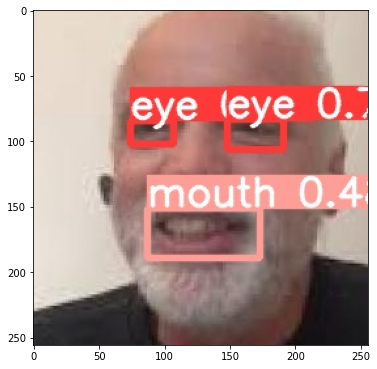

In [ ]:
X = cv2.imread('runs/detect/exp/FM000155_01.jpg') # ver path en las ultimas lineas de la ejecución anterior

plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(X, cv2.COLOR_BGR2RGB))
plt.show()



## Estadísticas en validación

In [ ]:
!python val.py --weights {TEST_WEIGHTS} --data {YAMLFILE} --img {IMG_SIZE} --iou 0.25 --half

val: data=../data/data.yaml, weights=['runs/train/exp/weights/last.pt'], batch_size=32, imgsz=256, conf_thres=0.001, iou_thres=0.25, task=val, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True
YOLOv5 🚀 v6.0-35-ga4fece8 torch 1.9.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
Model Summary: 213 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '../data/labels/val.cache' images and labels... 14 found, 0 missing, 0 empty, 0 corrupted: 100% 14/14 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 1/1 [00:00<00:00,  2.24it/s]
                 all         14         35      0.552      0.714      0.526      0.141
                 eye         14         28      0.741      0.857      0.816      0.221
               mouth         14          7      0.364      0.571      

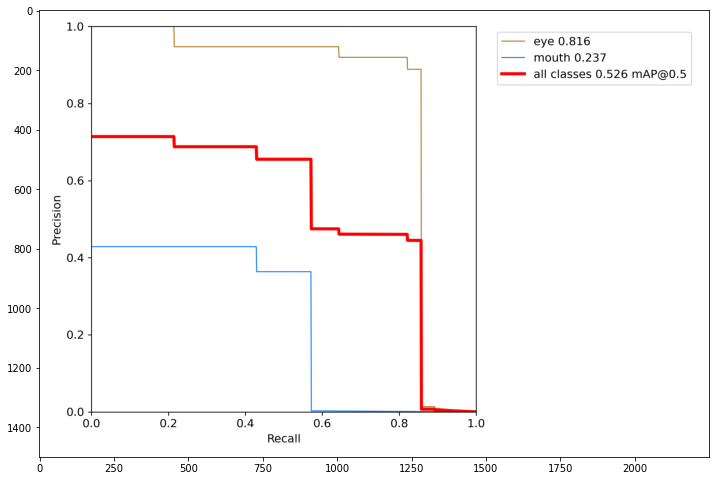

In [ ]:
I = cv2.imread('runs/val/exp/PR_curve.png') # ver path en las ultimas lineas de la ejecución anterior
plt.figure(figsize=(12,12))
plt.imshow(I)
plt.show()

## Estadísticas en testing

In [ ]:
!python val.py --weights {TEST_WEIGHTS} --data {YAMLFILE} --img {IMG_SIZE} --iou 0.25 --task test

val: data=../data/data.yaml, weights=['runs/train/exp/weights/last.pt'], batch_size=32, imgsz=256, conf_thres=0.001, iou_thres=0.25, task=test, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False
YOLOv5 🚀 v6.0-35-ga4fece8 torch 1.9.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
Model Summary: 213 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning '../data/labels/test' images and labels...59 found, 0 missing, 0 empty, 0 corrupted: 100% 59/59 [00:00<00:00, 1950.72it/s]
test: New cache created: ../data/labels/test.cache
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 2/2 [00:01<00:00,  1.42it/s]
                 all         59        147      0.729      0.589      0.522      0.131
                 eye         59        118      0.849      0.695      0.709       0.18
            

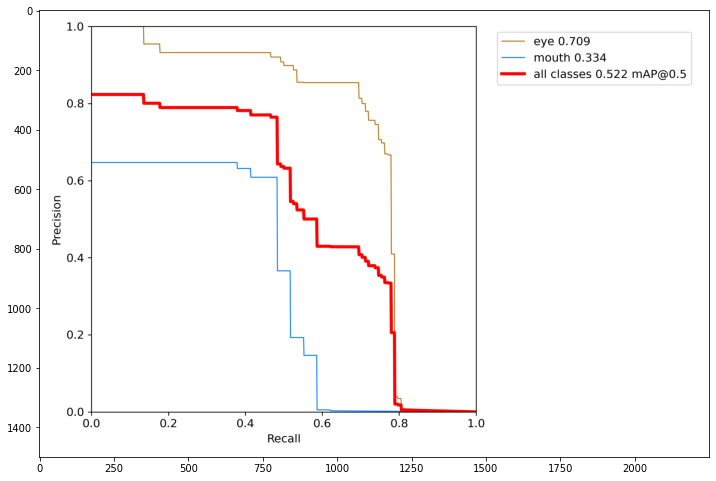

In [ ]:
I = cv2.imread('runs/val/exp2/PR_curve.png')  # ver path en las ultimas lineas de la ejecución anterior
plt.figure(figsize=(12,12))
plt.imshow(I)
plt.show()

## Despliegue de resultados

In [ ]:
def plot_boundingbox(iname,img_path,label_path):
  img_name = img_path +'/'+iname
  print('image:',img_name)
  X = cv2.imread(img_name)
  N = X.shape[0]
  M = X.shape[1]
  plt.figure(figsize=(12,12))
  plt.imshow(cv2.cvtColor(X, cv2.COLOR_BGR2RGB))
  plt.title(iname)
  lname = label_path+iname[:-4]+'.txt'
  print(' bbox:',lname)
  if os.path.isfile(lname):
    arr = np.loadtxt(lname)
    if len(arr.shape)==1:
      n = 1
    else:
      n = arr.shape[0]
    for k in range(n):
      if n>1:
        z = arr[k,:]
      else:
        z = arr
      cl = int(z[0]) # object class
      x = z[1]*M
      y = z[2]*N
      w2 = z[3]*M/2
      h2 = z[4]*N/2
      x1 = x-w2
      x2 = x+w2
      y1 = y-h2
      y2 = y+h2
      plt.plot([x1,x1,x2,x2,x1],[y1,y2,y2,y1,y1],'g')
      plt.text(x1,y1,str(cl),bbox=dict(facecolor='red', alpha=0.5))
      #k = k+1

  plt.show()


In [ ]:
tpath = '../data/images/test/'
lpath = '../data/labels/test/'
img_names = dirfiles(tpath,'*.jpg')
i = 0

image: runs/detect/exp//FM000145_04.jpg
 bbox: ../data/labels/test/FM000145_04.txt


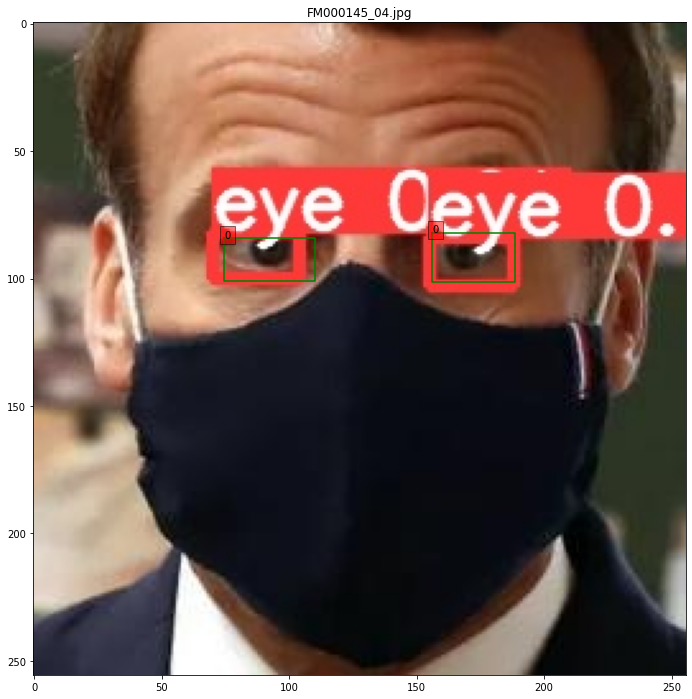

In [ ]:
i = i+2
iname = img_names[i]
img_path = 'runs/detect/exp/' # ver path en las ultimas lineas de la ejecución de 'deteccion en testing'
label_path = lpath # ground truth
plot_boundingbox(iname,img_path,label_path)

## Detección en una imagen de pruebas nueva

Se carga en nuevo directorio la(s) imagen(es) a probar y se corre `deetect.py` como se corrió en uno de los pasos anteriores:

In [ ]:
!wget https://www.dropbox.com/s/s5aoodi4n6xdffb/2.png

--2021-10-25 18:59:51--  https://www.dropbox.com/s/s5aoodi4n6xdffb/2.png
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/s5aoodi4n6xdffb/2.png [following]
--2021-10-25 18:59:51--  https://www.dropbox.com/s/raw/s5aoodi4n6xdffb/2.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9ee0ecd937b2857a959c2349c5.dl.dropboxusercontent.com/cd/0/inline/BYtVsHF1YHc0wI9abPNY0AP6OZru4XjPBYiMIh7TGeuclvT2h9HbqAUiaJpPLf5OLSkPM8bP-65DVpwzzmkIaeGmtQdOKHwjzXszV0oPgTPZrfQ0Jh8ZnEkj5gpvW64kEKGEaRVgOpOUIRjC1GVmwOrO/file# [following]
--2021-10-25 18:59:51--  https://uc9ee0ecd937b2857a959c2349c5.dl.dropboxusercontent.com/cd/0/inline/BYtVsHF1YHc0wI9abPNY0AP6OZru4XjPBYiMIh7TGeuclvT2h9HbqAUiaJpPLf5OLSkPM8bP-65DVpwzzmkIaeGmtQdOKHwjzXszV0oPgTPZrfQ

In [ ]:
NEW_PATH_TEST = '../newtest'
TEST_IMAGE    = '2.png'

In [ ]:
!mkdir {NEW_PATH_TEST}

In [ ]:
!cp {TEST_IMAGE} {NEW_PATH_TEST}

In [ ]:
!python detect.py --weights {TEST_WEIGHTS} --img 256 --conf 0.4 --source  {NEW_PATH_TEST} --save-txt

detect: weights=['runs/train/exp/weights/last.pt'], source=../newtest, imgsz=[256, 256], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-35-ga4fece8 torch 1.9.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
Model Summary: 213 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/newtest/2.png: 256x256 2 eyes, 1 mouth, Done. (0.010s)
Speed: 0.3ms pre-process, 10.1ms inference, 1.5ms NMS per image at shape (1, 3, 256, 256)
Results saved to runs/detect/exp2
1 labels saved to runs/detect/exp2/labels


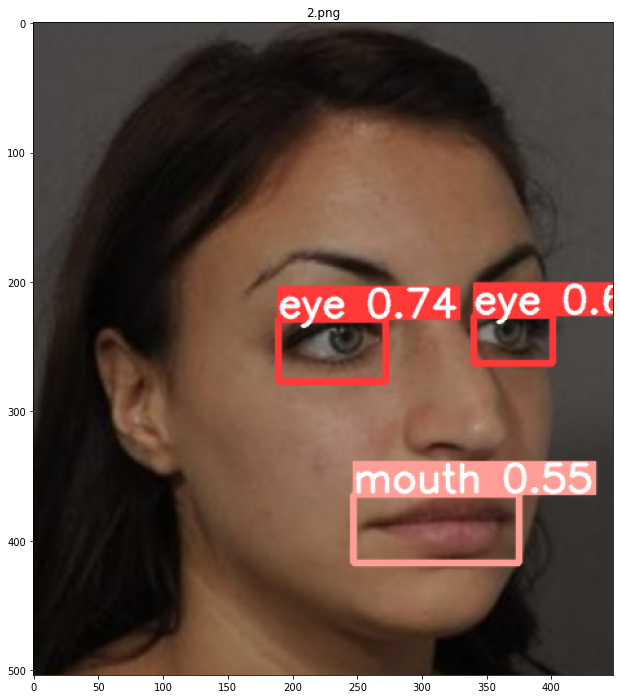

In [ ]:
X = cv2.imread('runs/detect/exp2/'+TEST_IMAGE) # ver path en las ultimas lineas de la ejecución anterior
plt.figure(figsize=(12,12))
plt.imshow(cv2.cvtColor(X, cv2.COLOR_BGR2RGB))
plt.title(TEST_IMAGE)
plt.show()


image: ../newtest/2.png
 bbox: runs/detect/exp2/labels/2.txt


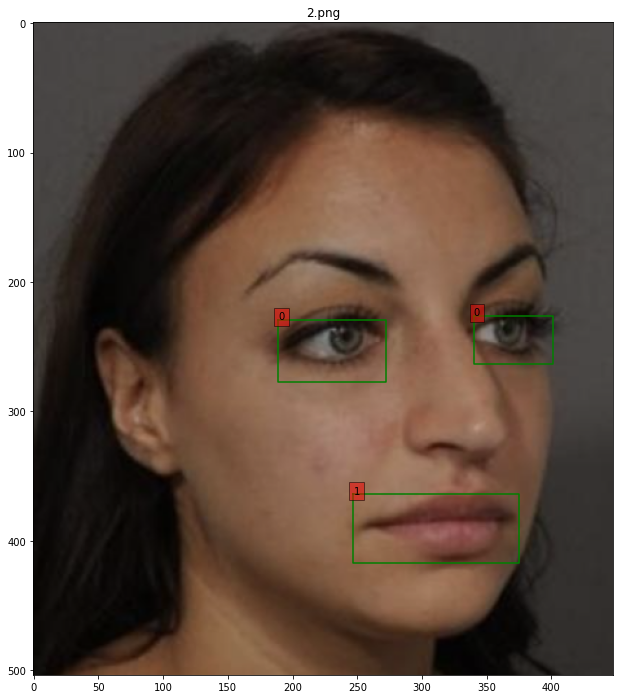

In [ ]:
iname = TEST_IMAGE
img_path = NEW_PATH_TEST
label_path = 'runs/detect/exp2/labels/' # ver path en las ultimas lineas de la ejecución anterior
plot_boundingbox(iname,img_path,label_path)